# Trending YouTube Categories insights
-------------------------------------------------------------------------------------

## Imports

In [466]:
import numpy as np
import pandas as pd
from datetime import date

In [467]:
# Read the YouTube DataSet and Categories from JSON file
json_path = '/Users/matthew/Desktop/python_project/US_category_id.json'
yt_df = pd.read_csv('/Users/matthew/Desktop/python_project/USvideos.csv')
yt_json = pd.read_json(json_path, orient='columns')
cat_json = pd.read_json((yt_json['items']).to_json() , orient='index')
categories_table = pd.read_json((cat_json['snippet']).to_json() , orient='index')

# group id with value to create dictionary
cat_ids = cat_json['id']
cat_titles = categories_table['title']

# contains category id as the key and category as the value
cat_dict = dict(zip(cat_ids, cat_titles))


## Add columns to data frame (categories, number_of_tags, days_before_trending)

In [468]:

# ------------------------------------ Adding categories ------------------------------------
# storing id column from yt_db
cat_id_list_from_main_db = yt_df['category_id']

# Checks every category id in a row and adds a category as a string
categories_col = [v.lower() for catId in cat_id_list_from_main_db for k, v in cat_dict.items() if catId == k]

# add new column to yt_db 
yt_df['categories'] = categories_col


# ------------------------------------ number_of_tags ------------------------------------

tags_list = list(yt_df['tags'])
tags_list

number_of_tags_col = [len(tag.split('|')) for tag in tags_list]

yt_df['number_of_tags'] = number_of_tags_col


# ------------------------------------ days_before_trending ------------------------------------


# TREND DATES
trend_date = yt_df['trending_date']
publish_date = yt_df['publish_time']
trend_dates = []
publish_dates = []
days_before_trending = []


for i in trend_date:

    trend_date = i.split('.')

    # YEAR
    trend_year = str(20) + trend_date[0]

    # MONTH
    trend_month = trend_date[2]
    if (trend_month[0] == str(0)):
        trend_month = trend_month[1]
    else:
        trend_month = trend_date[2]
        
    # DAY
    trend_day = trend_date[1]
    if (trend_day[0] == str(0)):
        trend_day = trend_day[1]
    else:
        trend_day = trend_date[1]
        
    trend_dates.append(trend_year + "/" + trend_month + "/" + trend_day)
    
    

# PUBLISH DATES

for j in publish_date:
    publish_date = j.split('-')
    
    # YEAR
    publish_year = publish_date[0]
    
    # MONTH
    publish_month = publish_date[1]
    if(publish_month[0] == str(0)):
        publish_month = publish_month[1]
    else:
        publish_month = publish_date[1] 
    
    # DAY
    publish_day = publish_date[2][:2]    

    if(publish_day[0] == str(0)):
        publish_day = publish_day[1]
    else:
        publish_day = publish_date[2][:2]
    
        
    publish_dates.append(publish_year + "/" + publish_month + "/" + publish_day)


videos = zip(publish_dates, trend_dates)
    
# CALCULATE DAYS
for p_date, t_date in videos:
    p_date = p_date.split('/')
    t_date = t_date.split('/')
    
    # PARSE
    p_year = int(p_date[0])
    t_year = int(t_date[0])

    p_month = int(p_date[1])
    t_month = int(t_date[1])
    
    p_day = int(p_date[2])
    t_day = int(t_date[2])
        
    
    upload = date(p_year, p_month, p_day)
    trend = date(t_year, t_month, t_day)
    delta = trend - upload
    days_before_trending.append(delta.days)

yt_df['days_before_trending'] = days_before_trending
yt_df


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,categories,number_of_tags,days_before_trending
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,people & blogs,1,1
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",entertainment,4,1
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,comedy,23,2
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,entertainment,27,1
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,entertainment,14,2
5,gHZ1Qz0KiKM,17.14.11,2 Weeks with iPhone X,iJustine,28,2017-11-13T19:07:23.000Z,"ijustine|""week with iPhone X""|""iphone x""|""appl...",119180,9763,511,1434,https://i.ytimg.com/vi/gHZ1Qz0KiKM/default.jpg,False,False,False,Using the iPhone for the past two weeks -- her...,science & technology,7,1
6,39idVpFF7NQ,17.14.11,Roy Moore & Jeff Sessions Cold Open - SNL,Saturday Night Live,24,2017-11-12T05:37:17.000Z,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",2103417,15993,2445,1970,https://i.ytimg.com/vi/39idVpFF7NQ/default.jpg,False,False,False,Embattled Alabama Senate candidate Roy Moore (...,entertainment,42,2
7,nc99ccSXST0,17.14.11,5 Ice Cream Gadgets put to the Test,CrazyRussianHacker,28,2017-11-12T21:50:37.000Z,"5 Ice Cream Gadgets|""Ice Cream""|""Cream Sandwic...",817732,23663,778,3432,https://i.ytimg.com/vi/nc99ccSXST0/default.jpg,False,False,False,Ice Cream Pint Combination Lock - http://amzn....,science & technology,13,2
8,jr9QtXwC9vc,17.14.11,The Greatest Showman | Official Trailer 2 [HD]...,20th Century Fox,1,2017-11-13T14:00:23.000Z,"Trailer|""Hugh Jackman""|""Michelle Williams""|""Za...",826059,3543,119,340,https://i.ytimg.com/vi/jr9QtXwC9vc/default.jpg,False,False,False,"Inspired by the imagination of P.T. Barnum, Th...",film & animation,28,1
9,TUmyygCMMGA,17.14.11,Why the rise of the robots won’t mean the end ...,Vox,25,2017-11-13T13:45:16.000Z,"vox.com|""vox""|""explain""|""shift change""|""future...",256426,12654,1363,2368,https://i.ytimg.com/vi/TUmyygCMMGA/default.jpg,False,False,False,"For now, at least, we have better things to wo...",news & politics,20,1


# Helper Methods

In [463]:
def likeToDislikeRatio(likes, dislikes):
    likesRatio = (likes / (likes + dislikes)) * 100 
    return likesRatio

# likeToDislikeRatio(2334, 3246)


def filterByCategory(category):
    df_filtered = yt_df[yt_df['categories'].str.contains(category)]
    return df_filtered

# filterByCategory('comedy')


# Work in progress

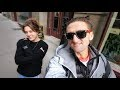

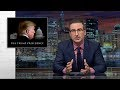

In [464]:
from IPython.core.display import Image, display, HTML
# display(Image('https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg', width=256, unconfined=True))
# display(Image('https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg', width=256, unconfined=True))

thumbnails = [[display(Image('https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg', width=256, unconfined=True)), 
              display(Image('https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg', width=256, unconfined=True))]]

image_df = pd.DataFrame(thumbnails)

image_df

def path_to_image_html(path):
    '''
     This function essentially convert the image url to 
     '<img src="'+ path + '"/>' format. And one can put any
     formatting adjustments to control the height, aspect ratio, size etc.
     within as in the below example. 
    '''

    return '<img src="'+ path + '" style=max-height:124px;"/>'

HTML(image_df.to_html(escape=False ,formatters=dict(column_name_with_image_links=path_to_image_html)))

x = path_to_image_html('https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg')
y = path_to_image_html('https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg')


display(HTML(x))
display(HTML(y))